In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False)

100%|██████████| 170M/170M [00:06<00:00, 25.7MB/s]


In [3]:
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.fc(x)

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [5]:
def train_model(model, trainloader, testloader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Evaluate
        model.eval()
        test_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f} | "
              f"Test Loss: {test_losses[-1]:.4f} | "
              f"Accuracy: {100.*correct/total:.2f}%")

    return train_losses, test_losses

In [6]:
print("Training Fully Connected NN...")
fc_model = FullyConnectedNN()
fc_train_losses, fc_test_losses = train_model(fc_model, trainloader, testloader, epochs=10)

print("\nTraining CNN...")
cnn_model = SimpleCNN()
cnn_train_losses, cnn_test_losses = train_model(cnn_model, trainloader, testloader, epochs=10)

Training Fully Connected NN...
Epoch 1/10 | Train Loss: 1.6339 | Test Loss: 1.4892 | Accuracy: 46.63%
Epoch 2/10 | Train Loss: 1.4105 | Test Loss: 1.4027 | Accuracy: 50.79%
Epoch 3/10 | Train Loss: 1.2973 | Test Loss: 1.3773 | Accuracy: 52.22%
Epoch 4/10 | Train Loss: 1.2042 | Test Loss: 1.3313 | Accuracy: 53.38%
Epoch 5/10 | Train Loss: 1.1223 | Test Loss: 1.3282 | Accuracy: 54.07%
Epoch 6/10 | Train Loss: 1.0367 | Test Loss: 1.3635 | Accuracy: 54.11%
Epoch 7/10 | Train Loss: 0.9581 | Test Loss: 1.3726 | Accuracy: 53.97%
Epoch 8/10 | Train Loss: 0.8824 | Test Loss: 1.4298 | Accuracy: 53.86%
Epoch 9/10 | Train Loss: 0.8090 | Test Loss: 1.4479 | Accuracy: 54.93%
Epoch 10/10 | Train Loss: 0.7305 | Test Loss: 1.5036 | Accuracy: 54.50%

Training CNN...
Epoch 1/10 | Train Loss: 1.4412 | Test Loss: 1.1231 | Accuracy: 59.59%
Epoch 2/10 | Train Loss: 1.0118 | Test Loss: 0.9465 | Accuracy: 67.05%
Epoch 3/10 | Train Loss: 0.8277 | Test Loss: 0.8459 | Accuracy: 70.35%
Epoch 4/10 | Train Loss: 0.7

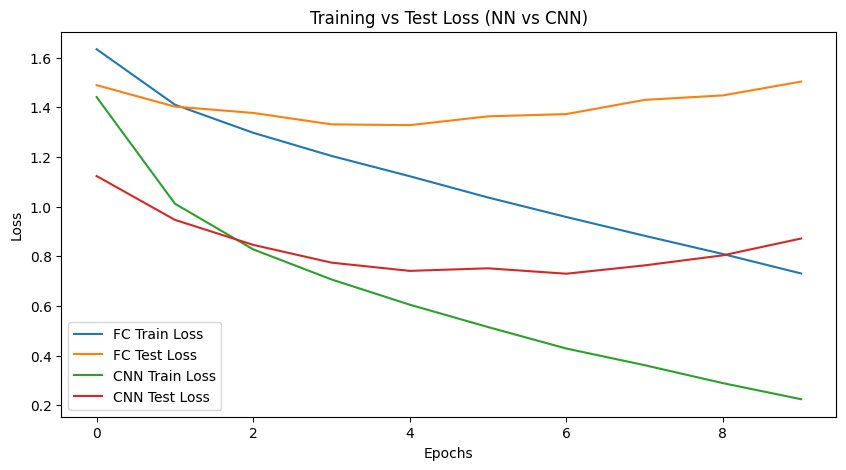

In [7]:
plt.figure(figsize=(10,5))
plt.plot(fc_train_losses, label="FC Train Loss")
plt.plot(fc_test_losses, label="FC Test Loss")
plt.plot(cnn_train_losses, label="CNN Train Loss")
plt.plot(cnn_test_losses, label="CNN Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Test Loss (NN vs CNN)")
plt.legend()
plt.show()